# The Ultimate Guide On RAG

Hello Kagglers! RAG, which stands for Retrieval Augmented Generation, is a technique used to enhance the knowledge base of large language models (LLMs) through the integration of external information. By doing so, LLMs are equipped to generate more context-aware responses and reduce instances of hallucination. This guide aims to offer an in-depth exploration of the RAG process.

First Let's look at some reasons why we may need RAG.

## Load Libray code need

In [ ]:
%%capture
!mamba install cudatoolkit xformers bitsandbytes pytorch pytorch-cuda=11.8 \
    -c pytorch -c nvidia -c xformers -c conda-forge -y
!pip install "unsloth[kaggle] @ git+https://github.com/unslothai/unsloth.git"
!pip uninstall datasets -y
!pip install datasets

import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
!pip install xformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -q bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.4 MB/s eta 0:00:00


## Build model QA basic without RAG

In [76]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
    "unsloth/gemma-7b-it-bnb-4bit", # Instruct version of Gemma 7b
    "unsloth/gemma-2b-bnb-4bit",
    "unsloth/gemma-2b-it-bnb-4bit", # Instruct version of Gemma 2b
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "openchat/openchat-3.5-0106-gemma", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2024.11.5: Fast Gemma patching. Transformers = 4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 7.5. CUDA Toolkit = 12.4.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model = FastLanguageModel.for_inference(model) # This line is added to fix the error

In [ ]:
# Defining the prompt
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

In [ ]:
def get_response(query, input=None):

    inputs = tokenizer(
    [
        prompt.format(
            query, # instruction
            "", # input
            "", # output - leave this blank for generation!
        )
    ], return_tensors = "pt").to("cuda")

    outputs = model.generate(**inputs,  max_new_tokens = 256, use_cache = True)
    answer = tokenizer.batch_decode(outputs)[0]
    return answer.split("Response:\n")[-1]

### Example for correct

In [ ]:
print(get_response("What are the contributions of the 'Attention is all you need' paper?"))

The 'Attention is all you need' paper, also known as the Transformer paper, introduced a new architecture for neural networks called the Transformer. The main contributions of this paper are:

1. Emphasizing the importance of attention mechanisms in neural networks, which allows the model to focus on relevant parts of the input data and improve its performance.
2. Eliminating the need for recurrent or convolutional layers, which were commonly used in previous architectures.
3. Demonstrating that the Transformer architecture can achieve state-of-the-art results in various NLP tasks, such as machine translation, text summarization, and sentiment analysis, without the need for large amounts of training data or computational resources.
4. Providing a foundation for the development of many subsequent models and techniques in the field of natural language processing and deep learning.<end_of_turn>


It turns out the Gemma model really hit the mark with its answer this time. Chances are, it's familiar with the super popular paper ["Attention is all you need,"](https://arxiv.org/abs/1706.03762) which likely showed up in its training data. Now, let's switch gears and check out something newer on the scene: the paper titled ["Genie: Generative Interactive Environments"](https://arxiv.org/abs/2402.15391)

### Example for incorrect

In [ ]:
print(get_response("What are the contributions of the 'Genie' paper?"))

The 'Genie' paper, also known as "The Annotated Turing," is a seminal work by Alan Turing that laid the foundation for the development of artificial intelligence and modern computing. The key contributions of this paper are:

1. The introduction of the Turing Test, a method for determining if a machine can think like a human.
2. The development of the Turing Machine, a theoretical model of computation that forms the basis for all modern digital computers.
3. The exploration of the concept of computability, which deals with the limits of what can be computed by a machine.
4. The examination of the Church-Turing thesis, which posits that any algorithm that a human can perform can also be executed by a Turing Machine.

These contributions have had a significant impact on the fields of computer science, mathematics, and artificial intelligence, and continue to influence research and development in these areas today.<end_of_turn>


Woah! Looks like the model just spit out a bunch of random information instead of something helpful. This probably happened because Gemma isn't familiar with the "Genie" paper. It seems like this paper didn't make it into its pre-trained knowledge base.


### Problem

So, what's the fix here? You might think about retraining Gemma from scratch with the latest info, but let's be real—that's a no-go. Training these massive language models like Gemma from the ground up costs a fortune in time and money! And that's exactly where RAG comes to the rescue. The beauty of RAG technology is that it saves us from having to retrain the whole massive model every single time we need it to learn something new. Instead, we can just hook up the relevant knowledge bases as extra input for the model, boosting the accuracy of its responses without breaking the bank.

### Solve

RAG, short for **Retrieval Augmented Generation**, enhances the capabilities of large language models (LLMs) by incorporating a retrieval step into the process. When tasked with answering a question or generating text, RAG first seeks out relevant information from a vast repository of knowledge, which could include an array of documents and web pages. This approach allows the model to refine its generated responses by integrating this retrieved information, offering a more informed output that extends beyond its pre-trained knowledge base.


## What is Retrieval Augmented Generation?

RAG, short for Retrieval Augmented Generation, enhances the capabilities of large language models (LLMs) by incorporating a retrieval step into the process. When tasked with answering a question or generating text, RAG first seeks out relevant information from a vast repository of knowledge, which could include an array of documents and web pages. This approach allows the model to refine its generated responses by integrating this retrieved information, offering a more informed output that extends beyond its pre-trained knowledge base.


![image](https://miro.medium.com/v2/resize:fit:828/format:webp/1*bo0JwTdru5quxDiPFa1TvA.png)

picture coming from [this](https://ai.plainenglish.io/a-brief-introduction-to-retrieval-augmented-generation-rag-b7eb70982891) amazing blog post




Generally, there are 3 main steps in a RAG pipeline
- Indexing: The indexing process involves cleaning raw data and converting it to plain text from formats like PDF and HTML. This text is then divided into smaller pieces and converted into vectors. Finally, an index stores these pieces and their vectors for efficient searching.

- Retrieval: Retrieve relevant information from external sources based on user query. To find relevant information based on a user's query, the system performs a vector search or a hybrid search within a vector database.

- Generation: When a user poses a query, RAG takes that along with the context it retrieved and feeds them both into the large language model (LLM). This process enables the LLM to produce a more informed and accurate response by considering both the user's original question and the additional information sourced from the knowledge database.

Before diving into each part, let's define what we wanto to make!

## Problem formulation

In this tutorial, I want to design a chatbot that have the ability to understand and explain basic concepts about data science, machine learning, deep learning.

But not only that I want it as my personal research assistant, with the ability to:
- Find the latest papers, and give me a short overview of these papers.
- Explore and list all the papers of a certain topic.
- Could suggest some concepts that I could explore to understand a specific paper.


## Indexing

Let's start our exploration by zeroing in on the Indexing bit of RAG. Think of an Index as a cleverly organized digital filing cabinet, stuffed with Documents that a language model can sift through for answers. In this tutorial, we're going to use the `VectorStoreIndex` from llamaindex.

But first we need to prepare some data, in this note book, I will use the [arxiv dataset](https://www.kaggle.com/datasets/Cornell-University/arxiv/data)!

**Chỉ mục (Indexing)**

Hãy bắt đầu khám phá với phần **Chỉ mục (Indexing)** trong RAG (Retrieval-Augmented Generation). Hãy tưởng tượng một chỉ mục như là một chiếc tủ hồ sơ kỹ thuật số được tổ chức một cách thông minh, chứa đầy các tài liệu mà mô hình ngôn ngữ có thể lục lọi để tìm câu trả lời. Trong bài hướng dẫn này, chúng ta sẽ sử dụng **VectorStoreIndex** từ **llamaindex**.

Nhưng trước hết, chúng ta cần chuẩn bị một số dữ liệu. Trong bài hướng dẫn này, tôi sẽ sử dụng bộ dữ liệu **arxiv**!

In [ ]:
!pip install opendatasets

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"phctuynl","key":"ac18e8b634ddd4c5cf535d3d4897d655"}\r\n'}

In [ ]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/Cornell-University/arxiv')

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv


100%|██████████| 1.36G/1.36G [01:04<00:00, 22.6MB/s]


In [4]:
# All Arxiv category codes
# Source: https://www.kaggle.com/code/artgor/arxiv-metadata-exploration

# https://arxiv.org/category_taxonomy
# https://info.arxiv.org/help/api/user-manual.html#subject_classifications


category_map = {
# These created errors when mapping categories to descriptions
'acc-phys': 'Accelerator Physics',
'adap-org': 'Not available',
'q-bio': 'Not available',
'cond-mat': 'Not available',
'chao-dyn': 'Not available',
'patt-sol': 'Not available',
'dg-ga': 'Not available',
'solv-int': 'Not available',
'bayes-an': 'Not available',
'comp-gas': 'Not available',
'alg-geom': 'Not available',
'funct-an': 'Not available',
'q-alg': 'Not available',
'ao-sci': 'Not available',
'atom-ph': 'Atomic Physics',
'chem-ph': 'Chemical Physics',
'plasm-ph': 'Plasma Physics',
'mtrl-th': 'Not available',
'cmp-lg': 'Not available',
'supr-con': 'Not available',
###

# Added
'econ.GN': 'General Economics',
'econ.TH': 'Theoretical Economics',
'eess.SY': 'Systems and Control',

'astro-ph': 'Astrophysics',
'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
'astro-ph.EP': 'Earth and Planetary Astrophysics',
'astro-ph.GA': 'Astrophysics of Galaxies',
'astro-ph.HE': 'High Energy Astrophysical Phenomena',
'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
'astro-ph.SR': 'Solar and Stellar Astrophysics',
'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
'cond-mat.mtrl-sci': 'Materials Science',
'cond-mat.other': 'Other Condensed Matter',
'cond-mat.quant-gas': 'Quantum Gases',
'cond-mat.soft': 'Soft Condensed Matter',
'cond-mat.stat-mech': 'Statistical Mechanics',
'cond-mat.str-el': 'Strongly Correlated Electrons',
'cond-mat.supr-con': 'Superconductivity',
'cs.AI': 'Artificial Intelligence',
'cs.AR': 'Hardware Architecture',
'cs.CC': 'Computational Complexity',
'cs.CE': 'Computational Engineering, Finance, and Science',
'cs.CG': 'Computational Geometry',
'cs.CL': 'Computation and Language',
'cs.CR': 'Cryptography and Security',
'cs.CV': 'Computer Vision and Pattern Recognition',
'cs.CY': 'Computers and Society',
'cs.DB': 'Databases',
'cs.DC': 'Distributed, Parallel, and Cluster Computing',
'cs.DL': 'Digital Libraries',
'cs.DM': 'Discrete Mathematics',
'cs.DS': 'Data Structures and Algorithms',
'cs.ET': 'Emerging Technologies',
'cs.FL': 'Formal Languages and Automata Theory',
'cs.GL': 'General Literature',
'cs.GR': 'Graphics',
'cs.GT': 'Computer Science and Game Theory',
'cs.HC': 'Human-Computer Interaction',
'cs.IR': 'Information Retrieval',
'cs.IT': 'Information Theory',
'cs.LG': 'Machine Learning',
'cs.LO': 'Logic in Computer Science',
'cs.MA': 'Multiagent Systems',
'cs.MM': 'Multimedia',
'cs.MS': 'Mathematical Software',
'cs.NA': 'Numerical Analysis',
'cs.NE': 'Neural and Evolutionary Computing',
'cs.NI': 'Networking and Internet Architecture',
'cs.OH': 'Other Computer Science',
'cs.OS': 'Operating Systems',
'cs.PF': 'Performance',
'cs.PL': 'Programming Languages',
'cs.RO': 'Robotics',
'cs.SC': 'Symbolic Computation',
'cs.SD': 'Sound',
'cs.SE': 'Software Engineering',
'cs.SI': 'Social and Information Networks',
'cs.SY': 'Systems and Control',
'econ.EM': 'Econometrics',
'eess.AS': 'Audio and Speech Processing',
'eess.IV': 'Image and Video Processing',
'eess.SP': 'Signal Processing',
'gr-qc': 'General Relativity and Quantum Cosmology',
'hep-ex': 'High Energy Physics - Experiment',
'hep-lat': 'High Energy Physics - Lattice',
'hep-ph': 'High Energy Physics - Phenomenology',
'hep-th': 'High Energy Physics - Theory',
'math.AC': 'Commutative Algebra',
'math.AG': 'Algebraic Geometry',
'math.AP': 'Analysis of PDEs',
'math.AT': 'Algebraic Topology',
'math.CA': 'Classical Analysis and ODEs',
'math.CO': 'Combinatorics',
'math.CT': 'Category Theory',
'math.CV': 'Complex Variables',
'math.DG': 'Differential Geometry',
'math.DS': 'Dynamical Systems',
'math.FA': 'Functional Analysis',
'math.GM': 'General Mathematics',
'math.GN': 'General Topology',
'math.GR': 'Group Theory',
'math.GT': 'Geometric Topology',
'math.HO': 'History and Overview',
'math.IT': 'Information Theory',
'math.KT': 'K-Theory and Homology',
'math.LO': 'Logic',
'math.MG': 'Metric Geometry',
'math.MP': 'Mathematical Physics',
'math.NA': 'Numerical Analysis',
'math.NT': 'Number Theory',
'math.OA': 'Operator Algebras',
'math.OC': 'Optimization and Control',
'math.PR': 'Probability',
'math.QA': 'Quantum Algebra',
'math.RA': 'Rings and Algebras',
'math.RT': 'Representation Theory',
'math.SG': 'Symplectic Geometry',
'math.SP': 'Spectral Theory',
'math.ST': 'Statistics Theory',
'math-ph': 'Mathematical Physics',
'nlin.AO': 'Adaptation and Self-Organizing Systems',
'nlin.CD': 'Chaotic Dynamics',
'nlin.CG': 'Cellular Automata and Lattice Gases',
'nlin.PS': 'Pattern Formation and Solitons',
'nlin.SI': 'Exactly Solvable and Integrable Systems',
'nucl-ex': 'Nuclear Experiment',
'nucl-th': 'Nuclear Theory',
'physics.acc-ph': 'Accelerator Physics',
'physics.ao-ph': 'Atmospheric and Oceanic Physics',
'physics.app-ph': 'Applied Physics',
'physics.atm-clus': 'Atomic and Molecular Clusters',
'physics.atom-ph': 'Atomic Physics',
'physics.bio-ph': 'Biological Physics',
'physics.chem-ph': 'Chemical Physics',
'physics.class-ph': 'Classical Physics',
'physics.comp-ph': 'Computational Physics',
'physics.data-an': 'Data Analysis, Statistics and Probability',
'physics.ed-ph': 'Physics Education',
'physics.flu-dyn': 'Fluid Dynamics',
'physics.gen-ph': 'General Physics',
'physics.geo-ph': 'Geophysics',
'physics.hist-ph': 'History and Philosophy of Physics',
'physics.ins-det': 'Instrumentation and Detectors',
'physics.med-ph': 'Medical Physics',
'physics.optics': 'Optics',
'physics.plasm-ph': 'Plasma Physics',
'physics.pop-ph': 'Popular Physics',
'physics.soc-ph': 'Physics and Society',
'physics.space-ph': 'Space Physics',
'q-bio.BM': 'Biomolecules',
'q-bio.CB': 'Cell Behavior',
'q-bio.GN': 'Genomics',
'q-bio.MN': 'Molecular Networks',
'q-bio.NC': 'Neurons and Cognition',
'q-bio.OT': 'Other Quantitative Biology',
'q-bio.PE': 'Populations and Evolution',
'q-bio.QM': 'Quantitative Methods',
'q-bio.SC': 'Subcellular Processes',
'q-bio.TO': 'Tissues and Organs',
'q-fin.CP': 'Computational Finance',
'q-fin.EC': 'Economics',
'q-fin.GN': 'General Finance',
'q-fin.MF': 'Mathematical Finance',
'q-fin.PM': 'Portfolio Management',
'q-fin.PR': 'Pricing of Securities',
'q-fin.RM': 'Risk Management',
'q-fin.ST': 'Statistical Finance',
'q-fin.TR': 'Trading and Market Microstructure',
'quant-ph': 'Quantum Physics',
'stat.AP': 'Applications',
'stat.CO': 'Computation',
'stat.ME': 'Methodology',
'stat.ML': 'Machine Learning',
'stat.OT': 'Other Statistics',
'stat.TH': 'Statistics Theory'
}


In [5]:
# https://www.kaggle.com/code/matthewmaddock/nlp-arxiv-dataset-transformers-and-umap

# This takes about 1 minute.
import json
import pandas as pd

cols = ['id', 'title', 'abstract', 'categories']
data = []
file_name = '/content/arxiv/arxiv-metadata-oai-snapshot.json'


with open(file_name, encoding='latin-1') as f:
    for line in f:
        doc = json.loads(line)
        lst = [doc['id'], doc['title'], doc['abstract'], doc['categories']]
        data.append(lst)

df_data = pd.DataFrame(data=data, columns=cols)

print(df_data.shape)

df_data.head()

(2601564, 4)


,id,title,abstract,categories
0,0704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph
1,0704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG
2,0704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,physics.gen-ph
3,0704.0004,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...,math.CO
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...,math.CA math.FA


Maybe I just care about some cs topics

In [6]:
topics = ['cs.AI', 'cs.CV', 'cs.IR', 'cs.LG', 'cs.CL']

filtered_data = df_data[df_data['categories'].isin(topics)]

In [7]:
len(filtered_data)

126006

In [8]:
df_data = filtered_data.sample(n=16384) # randomly sample some data for development purpose

In [9]:
df_data.head()

,id,title,abstract,categories
1647330,2205.02918,Generating Representative Samples for Few-Shot...,Few-shot learning (FSL) aims to learn new ca...,cs.CV
2008893,2402.11254,C-ICL: Contrastive In-context Learning for Inf...,There has been increasing interest in explor...,cs.CL
1527113,2109.04292,Generalised Unsupervised Domain Adaptation of ...,This paper considers the unsupervised domain...,cs.CL
1227437,2001.02024,Deep Reinforcement Learning for Active Human P...,Most 3d human pose estimation methods assume...,cs.CV
264457,1105.5196,Large-Scale Music Annotation and Retrieval: Le...,Music prediction tasks range from predicting...,cs.LG


Data preprocessing

In [10]:
# https://www.kaggle.com/code/vbookshelf/part-1-build-an-arxiv-rag-search-system-w-faiss

def get_cat_text(x):

    cat_text = ''

    # Put the codes into a list
    cat_list = x.split(' ')

    for i, item in enumerate(cat_list):

        cat_name = category_map[item]

        # If there was no description available
        # for the category code then don't include it in the text.
        if cat_name != 'Not available':

            if i == 0:
                cat_text = cat_name
            else:
                cat_text = cat_text + ', ' + cat_name

    # Remove leading and trailing spaces
    cat_text = cat_text.strip()

    return cat_text


df_data['cat_text'] = df_data['categories'].apply(get_cat_text)

def clean_text(x):

    # Replace newline characters with a space
    new_text = x.replace("\n", " ")
    # Remove leading and trailing spaces
    new_text = new_text.strip()

    return new_text

df_data['title'] = df_data['title'].apply(clean_text)
df_data['abstract'] = df_data['abstract'].apply(clean_text)

df_data['prepared_text'] = df_data['title'] + ' \n ' + df_data['abstract']
df_data.head()

,id,title,abstract,categories,cat_text,prepared_text
1647330,2205.02918,Generating Representative Samples for Few-Shot...,Few-shot learning (FSL) aims to learn new cate...,cs.CV,Computer Vision and Pattern Recognition,Generating Representative Samples for Few-Shot...
2008893,2402.11254,C-ICL: Contrastive In-context Learning for Inf...,There has been increasing interest in explorin...,cs.CL,Computation and Language,C-ICL: Contrastive In-context Learning for Inf...
1527113,2109.04292,Generalised Unsupervised Domain Adaptation of ...,This paper considers the unsupervised domain a...,cs.CL,Computation and Language,Generalised Unsupervised Domain Adaptation of ...
1227437,2001.02024,Deep Reinforcement Learning for Active Human P...,Most 3d human pose estimation methods assume t...,cs.CV,Computer Vision and Pattern Recognition,Deep Reinforcement Learning for Active Human P...
264457,1105.5196,Large-Scale Music Annotation and Retrieval: Le...,Music prediction tasks range from predicting t...,cs.LG,Machine Learning,Large-Scale Music Annotation and Retrieval: Le...


In [12]:
!pip install -q llama-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.8/176.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.0 MB/s eta 0:00:00


In [11]:
from llama_index.core import Document

arxiv_documents = [Document(text=item) for item in list(df_data['prepared_text'])]

In [13]:
arxiv_documents[0]

Document(id_='21147574-a56e-4321-a3fc-a91458ca8c3d', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='Generating Representative Samples for Few-Shot Classification \n Few-shot learning (FSL) aims to learn new categories with a few visual samples per class. Few-shot class representations are often biased due to data scarcity. To mitigate this issue, we propose to generate visual samples based on semantic embeddings using a conditional variational autoencoder (CVAE) model. We train this CVAE model on base classes and use it to generate features for novel classes. More importantly, we guide this VAE to strictly generate representative samples by removing non-representative samples from the base training set when training the CVAE model. We show that this training scheme enhances the representativeness of the generated samples and therefore, improves the few-shot classification results. Experimental results show that our m

Now we already have the data, let's start creating the index!

### Creating Index with `VectorStoreIndex`

The `VectorStoreIndex` is by far the most frequently used type of Index in llamaindex. This class takes your Documents and splits them up into Nodes. Then, it creates `vector_embeddings` of the text of every node. But what is `vector_embedding`?

Vector embeddings are like turning the essence of your words into a mathematical sketch. Imagine every idea or concept in your text getting its unique numerical fingerprint. This is handy because even if two snippets of text use different words, if they're sharing the same idea, their numerical sketches—or embeddings—will be close neighbors in the numerical space. This magic is done using tools known as embedding models.

Choosing the right embedding model is crucial. It's like picking the right artist to paint your portrait; you want the one who captures you best. A great place to start is the MTEB leaderboard, where the crème de la crème of embedding models are ranked. As we have quite a large dataset, the model size matters, we don't want to wait all day for the model to extract all the vector embeddings. When I last checked, the `BAAI/bge-small-en-v1.5` model was leading the pack, especially considering its size. It could be a solid choice if you're diving into the world of text embeddings.


**Tạo Chỉ mục với VectorStoreIndex**

**VectorStoreIndex** là loại chỉ mục được sử dụng phổ biến nhất trong **llamaindex**. Lớp này sẽ nhận các **Documents** của bạn và chia chúng thành các **Nodes**. Sau đó, nó sẽ tạo **vector_embeddings** cho văn bản của mỗi node. Nhưng **vector_embedding** là gì?

**Vector embeddings** giống như việc biến bản chất của từ ngữ thành một bản phác thảo toán học. Hãy tưởng tượng mỗi ý tưởng hay khái niệm trong văn bản của bạn sẽ có một dấu vân tay số học riêng biệt. Điều này rất hữu ích vì ngay cả khi hai đoạn văn sử dụng những từ khác nhau, nhưng nếu chúng chia sẻ cùng một ý tưởng, các bản phác thảo số học của chúng—hay các embedding—sẽ ở gần nhau trong không gian số học. Phép màu này được thực hiện thông qua các công cụ gọi là **embedding models**.

Việc lựa chọn đúng **embedding model** rất quan trọng. Nó giống như việc chọn đúng họa sĩ để vẽ chân dung của bạn; bạn muốn người họa sĩ này nắm bắt được chính xác bản chất của bạn. Một nơi tốt để bắt đầu là **MTEB leaderboard**, nơi các **embedding models** hàng đầu được xếp hạng. Vì chúng ta có một bộ dữ liệu khá lớn, nên kích thước của mô hình rất quan trọng. Chúng ta không muốn phải đợi cả ngày để mô hình trích xuất tất cả các vector embeddings. Khi tôi kiểm tra lần cuối, mô hình **BAAI/bge-small-en-v1.5** dẫn đầu, đặc biệt là xét về kích thước của nó. Đây có thể là một lựa chọn tuyệt vời nếu bạn muốn tìm hiểu về **text embeddings**.

In [14]:
!pip install -q llama-index-embeddings-huggingface
!pip install -q llama-index-vector-stores-chroma

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.6/915.6 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.2/159.2 kB 13.8 MB/s eta 0:

In [15]:
!pip install -q llama-index-llms-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.8/402.8 kB 19.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2024.11.4 requires protobuf<4.0.0, but you have protobuf 5.28.3 which is incompatible.


In [16]:
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings
import chromadb
import torch
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext


# Create embed model for document
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5", cache_folder="./models", device=device_type)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Great! Now we have to find somewhere to store all of the embeddings extracted by the model, and that's why we need a `vector store`. There are many to choose from, in this tutorial, I will choose the `chroma` vector store

Tuyệt vời! Bây giờ chúng ta cần tìm một nơi để lưu trữ tất cả các **embeddings** đã được trích xuất bởi mô hình, và đó là lý do tại sao chúng ta cần một **vector store**. Có rất nhiều lựa chọn để chọn, trong hướng dẫn này, tôi sẽ chọn **chroma vector store**.

In [17]:
# Tạo một PersistentClient từ thư viện chromadb để lưu trữ và truy xuất dữ liệu vector
# Chroma sẽ lưu trữ dữ liệu vào thư mục ./DB
chroma_client = chromadb.PersistentClient(path="./DB")

# Lấy hoặc tạo một collection có tên "demo_arxiv" trong Chroma để lưu trữ các vector embeddings
chroma_collection = chroma_client.get_or_create_collection("demo_arxiv")

# Tạo một vector store từ collection Chroma. Vector store này sẽ lưu trữ các vector embeddings
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

# Tạo một StorageContext từ vector store. StorageContext này chứa thông tin về cách lưu trữ và truy xuất vector embeddings
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Tạo một VectorStoreIndex từ các tài liệu arxiv.
# Index này sẽ được tạo ra từ các tài liệu và được lưu trữ trong vector store
# embed_model là mô hình nhúng (embedding model) dùng để chuyển đổi các tài liệu thành vector embeddings
# show_progress=True để hiển thị tiến độ khi tạo index
index = VectorStoreIndex.from_documents(
    arxiv_documents,  # Tập hợp các tài liệu cần tạo index
    storage_context=storage_context,  # Context lưu trữ dữ liệu
    embed_model=embed_model,  # Mô hình nhúng dùng để tạo vector embeddings
    show_progress=True  # Hiển thị tiến độ khi xử lý
)


In [22]:
index = VectorStoreIndex.from_documents(
    arxiv_documents, storage_context=storage_context, embed_model=embed_model, show_progress=True
)

Parsing nodes:   0%|          | 0/16384 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Fantastic! We've successfully created a vector store for our data, laying down a solid foundation. To enhance this stage further, we could explore additional techniques like data preprocessing, text chunking, and node parsing. These methods can refine our data's quality and structure, potentially boosting our system's performance. However, to keep things straightforward and focused, we'll save these advanced topics for another time.

Tuyệt vời! Chúng ta đã tạo thành công một **vector store** cho dữ liệu của mình, xây dựng một nền tảng vững chắc. Để nâng cao thêm giai đoạn này, chúng ta có thể khám phá thêm các kỹ thuật như **tiền xử lý dữ liệu**, **chia đoạn văn bản**, và **phân tích node**. Những phương pháp này có thể cải thiện chất lượng và cấu trúc dữ liệu, từ đó nâng cao hiệu suất của hệ thống. Tuy nhiên, để giữ cho mọi thứ đơn giản và tập trung, chúng ta sẽ để những chủ đề nâng cao này cho một thời điểm khác.

**Loading from vector store**

Imagine you're executing this from a different script; there's no need to go through the hassle of recalculating the embeddings for all the documents again. You can simply load them up and dive straight into the task at hand.


Mã thêm văn bản Hãy tưởng tượng bạn đang thực thi điều này từ một tập lệnh khác; không cần phải tốn công sức tính toán lại phần nhúng cho tất cả tài liệu nữa. Bạn có thể chỉ cần tải chúng lên và lao thẳng vào nhiệm vụ trước mắt.


In [41]:
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext

embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5", cache_folder="./models", device=device_type) # must be the same as the previous stage

chroma_client = chromadb.PersistentClient(path="./DB")
chroma_collection = chroma_client.get_or_create_collection("demo_arxiv")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
# load the vectorstore
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_vector_store(vector_store, storage_context=storage_context, embed_model=embed_model)


Now, it's time to pivot to the next crucial phase: Retrieval.

# Retrieval

In the realm of digital information retrieval, the process known as similarity search within vector databases stands out for its efficiency and precision. This begins when a user's query is transformed into a vector embedding by the `embedding model`, which must be consistent with the model used during the indexing phase to ensure compatibility. Subsequently, `VectorStoreIndex` executes a mathematical operation to arrange the embeddings according to their semantic similarity to the query. The number of embeddings returned, determined by the parameter 'k', defines the scope of the search results, commonly referred to as 'top_k'. This methodology, known as "top-k semantic retrieval," is instrumental in refining search outcomes to present the most relevant results in a structured manner.


**Truy xuất thông tin**  

Trong lĩnh vực truy xuất thông tin kỹ thuật số, quy trình được gọi là "tìm kiếm tương tự" trong các cơ sở dữ liệu vector nổi bật nhờ vào hiệu quả và độ chính xác của nó. Quá trình này bắt đầu khi truy vấn của người dùng được chuyển đổi thành một vector nhúng (embedding) bởi mô hình nhúng. Mô hình này cần phải nhất quán với mô hình đã được sử dụng trong giai đoạn lập chỉ mục để đảm bảo tính tương thích. Sau đó, `VectorStoreIndex` sẽ thực hiện một phép toán toán học để sắp xếp các vector nhúng dựa trên mức độ tương đồng ngữ nghĩa với truy vấn. Số lượng vector nhúng được trả về được xác định bởi tham số 'k', quyết định phạm vi của kết quả tìm kiếm, thường được gọi là 'top_k'. Phương pháp này, được biết đến với tên gọi "truy xuất ngữ nghĩa top-k", đóng vai trò quan trọng trong việc tinh chỉnh kết quả tìm kiếm để đưa ra những kết quả có liên quan nhất theo cách có cấu trúc.

In [69]:
query_engine = index.as_retriever(
    similarity_top_k = 5,
    alpha=0.5,
)

In [70]:
for res in query_engine.retrieve("What are some papers about video generation using diffusion models?"):
    print(res.text)
    print("=============")

VideoControlNet: A Motion-Guided Video-to-Video Translation Framework by   Using Diffusion Model with ControlNet 
 Recently, diffusion models like StableDiffusion have achieved impressive image generation results. However, the generation process of such diffusion models is uncontrollable, which makes it hard to generate videos with continuous and consistent content. In this work, by using the diffusion model with ControlNet, we proposed a new motion-guided video-to-video translation framework called VideoControlNet to generate various videos based on the given prompts and the condition from the input video. Inspired by the video codecs that use motion information for reducing temporal redundancy, our framework uses motion information to prevent the regeneration of the redundant areas for content consistency. Specifically, we generate the first frame (i.e., the I-frame) by using the diffusion model with ControlNet. Then we generate other key frames (i.e., the P-frame) based on the previ

In [ ]:
# Import các thư viện cần thiết từ llama_index và chromadb
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext

# Thiết lập mô hình nhúng (embedding model) sử dụng HuggingFace
# 'BAAI/bge-small-en-v1.5' là tên của mô hình nhúng sử dụng tiếng Anh.
# cache_folder: thư mục để lưu trữ mô hình đã tải về.
# device: chọn sử dụng GPU ('cuda') nếu có, nếu không sẽ dùng CPU ('cpu').
embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5",
    cache_folder="./models",
    device=device_type  # device_type phải được định nghĩa trước đó
)

# Tạo một client để kết nối với cơ sở dữ liệu Chroma
# chroma_client sẽ lưu trữ dữ liệu vector embeddings trong thư mục ./DB
chroma_client = chromadb.PersistentClient(path="./DB")

# Lấy hoặc tạo một collection có tên "demo_arxiv" trong ChromaDB.
# Collection này sẽ được sử dụng để lưu trữ các vector embeddings của tài liệu.
chroma_collection = chroma_client.get_or_create_collection("demo_arxiv")

# Tạo một vector store từ collection Chroma.
# vector_store sử dụng chroma_collection để lưu trữ và truy xuất các vector embeddings.
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

# Tạo một StorageContext từ vector store.
# StorageContext này chứa thông tin về cách lưu trữ và truy xuất vector embeddings.
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Tạo một VectorStoreIndex từ vector store đã có sẵn.
# VectorStoreIndex này giúp thực hiện các thao tác tìm kiếm (search) hiệu quả dựa trên embeddings.
index = VectorStoreIndex.from_vector_store(
    vector_store,  # Sử dụng vector store đã tạo ở trên
    storage_context=storage_context,  # Context lưu trữ dữ liệu
    embed_model=embed_model  # Mô hình nhúng dùng để tính toán vector embeddings
)

# Tạo một công cụ truy vấn (retriever) từ index.
# as_retriever() giúp chuyển đổi index thành một truy vấn có thể thực hiện tìm kiếm.
# similarity_top_k = 5: chỉ định rằng chúng ta muốn lấy 5 kết quả có độ tương đồng cao nhất.
# alpha = 0.5: một tham số tuỳ chỉnh, có thể dùng để điều chỉnh trọng số hoặc mức độ ưu tiên.
query_engine = index.as_retriever(
    similarity_top_k=5,  # Số lượng kết quả hàng đầu cần truy xuất
    alpha=0.5  # Điều chỉnh trọng số (nếu có tác dụng trong mô hình này)
)

# Sử dụng query_engine để truy vấn các tài liệu có liên quan đến câu hỏi của người dùng.
# Câu truy vấn là: "What are some papers about video generation using diffusion models?"
for res in query_engine.retrieve("What are some papers about video generation using diffusion models?"):
    # In ra nội dung của từng kết quả truy vấn
    print(res.text)  # res.text chứa nội dung văn bản của tài liệu
    print("=============")  # Dùng để phân cách giữa các kết quả


### Reranking



**Reranking (Tái xếp hạng)**

Khi một retriever (công cụ truy xuất) lấy thông tin từ vector store, nó giống như việc quăng một chiếc lưới rộng – bạn sẽ bắt được rất nhiều thứ, nhưng không phải tất cả đều là thứ bạn muốn. Một số phần thông tin có thể không phù hợp, khiến ta dễ bị dẫn đi sai hướng. Đó chính là lúc tái xếp hạng (reranking) phát huy tác dụng. Hãy tưởng tượng việc tái xếp hạng như một vòng kiểm tra kỹ lưỡng thứ hai, một sự tinh chỉnh. Sau khi thu thập kết quả ban đầu từ tìm kiếm vector, tái xếp hạng sẽ bước vào để rà soát lại các kết quả này, sắp xếp lại thứ tự hoặc thứ hạng của các mục (trong trường hợp này là các tài liệu mà ta đã truy xuất) dựa trên các tiêu chí cụ thể hơn. Nó giống như việc đảm bảo rằng những thông tin tốt nhất, phù hợp nhất được đặt ở vị trí hàng đầu, sẵn sàng để chúng ta sử dụng. Bước bổ sung này giúp đảm bảo rằng những gì ta làm việc với đều có liên quan và hữu ích nhất có thể.

**Nhưng điều gì khiến các mô hình tái xếp hạng khác với công cụ truy xuất ban đầu?**
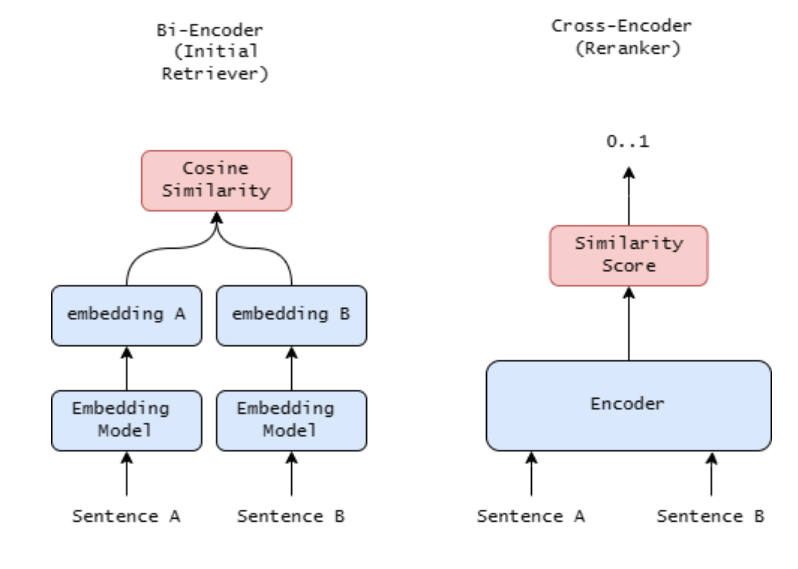
(Hình minh họa: Bi-Encoder vs Cross-Encoder)

Mô hình nhúng thông thường tuân theo mô hình **Bi-Encoder**, trong đó các vector embeddings cho tài liệu nguồn được tính toán trước. Trong giai đoạn truy vấn, mô hình sẽ tạo ra một embedding cho truy vấn của người dùng và sau đó tính điểm tương đồng Cosine với các tài liệu trong cơ sở dữ liệu để xác định những tài liệu phù hợp nhất.

Đối với quá trình tái xếp hạng, điều quan trọng là phải đưa cả tài liệu nguồn và truy vấn vào mô hình cùng lúc. Điều này cho phép mô hình đánh giá mức độ tương đồng giữa hai thực thể này. Phương pháp này có thể tốn rất nhiều thời gian vì nó không có lợi thế của việc sử dụng dữ liệu đã được tính toán trước. Tuy nhiên, tiềm năng để đạt được độ chính xác cao hơn là rất đáng kể. Do đó, quá trình tái xếp hạng thường chỉ áp dụng cho các tài liệu hàng đầu đã được truy xuất ban đầu bởi **Bi-Encoder**, đảm bảo sự cân bằng giữa hiệu suất và độ chính xác trong việc lựa chọn tài liệu.

When a retriever pulls information from the vector store, it's a bit like casting a wide net – you end up with a lot of catches, but not all of them are the fish you're after. Some pieces of context can be way off the mark, leading us down the wrong path. That's where reranking comes into play. Think of reranking as a second round of scrutiny, a fine-tuning of sorts. After the initial haul from the vector search, reranking steps in to sift through the catch, reorganizing the order or ranking of the items (in this case, the documents we've retrieved) based on more specific criteria. It's like making sure the best, most relevant pieces of information are right at the top, ready for us to use. This extra step helps ensure that what we're working with is as relevant and useful as possible.

Theo [clavie](https://x.com/bclavie/status/1765312881120153659)
"Just use a reranker for better retrieval"
...
Yes, but which one?

Someone asked me recently what reranker they should use (with no data to fine-tune it), and I realised just how loaded that question actually was, so I made this (mostly English) "cheatsheet"

"Chỉ cần sử dụng công cụ sắp xếp lại để truy xuất tốt hơn"
... Có, nhưng cái nào?

Gần đây có người đã hỏi tôi rằng họ nên sử dụng công cụ xếp hạng lại nào (không có dữ liệu để tinh chỉnh nó) và tôi nhận ra rằng câu hỏi đó thực sự tải đến mức nào, vì vậy tôi đã tạo ra "cheatsheet" này (chủ yếu là tiếng Anh)


But how are rerankers different from our initial retriever?

![Bi-Encoder vs Cross-Encoder.png]

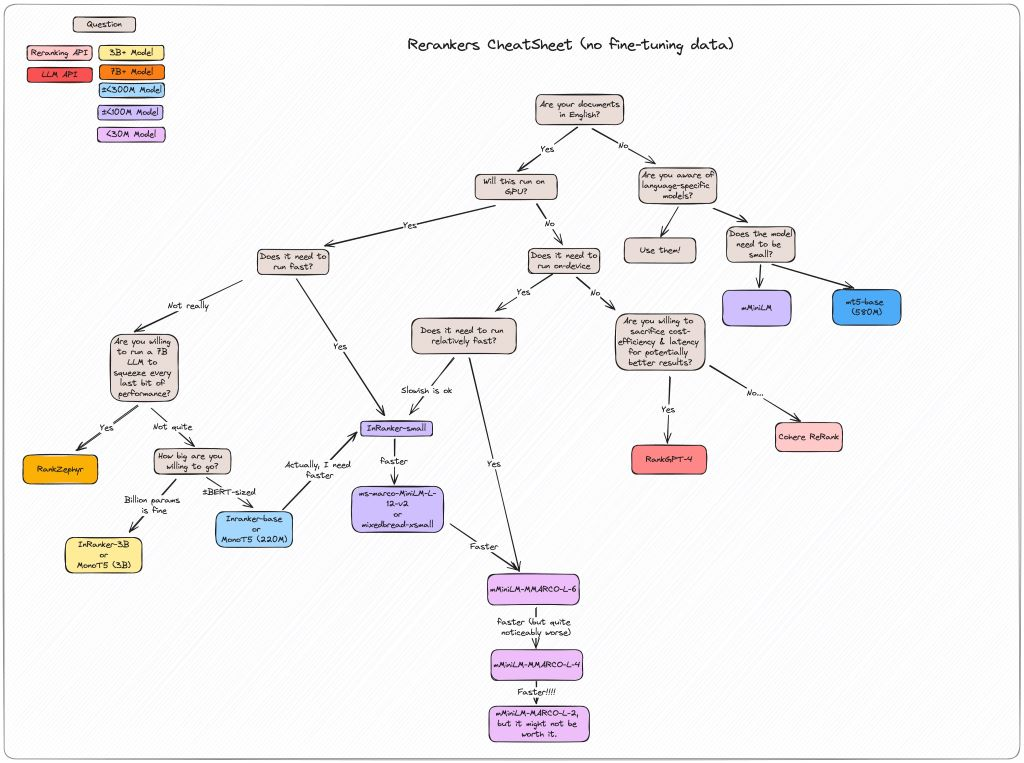

The conventional embedding model adheres to the Bi-Encoder paradigm, wherein embeddings for source documents are precomputed. During the query phase, the model generates an embedding for the user's query and then calculates the Cosine Similarity score across our database to identify the most relevant documents.

For the reranking process, it is essential to input both the source documents and the query concurrently into the model. This allows the model to evaluate the similarity between the two entities. This approach can be considerably time-intensive, as it lacks the advantage of precomputed data. However, the potential for enhanced accuracy is substantial. Therefore, the reranking process is reserved for the top documents initially retrieved by the Bi-Encoder, ensuring a balance between efficiency and precision in the document selection process.

**Reranking Cheatsheet**: Here is a useful reranking cheatsheet, originally in this [tweet](https://twitter.com/bclavie/status/1765312881120153659/photo/1). Thanks [@bclavie](https://twitter.com/bclavie)

![GH-ms_HWcAEYWou.jpg](attachment:a11dfc83-2499-4cdc-acf5-504879e08abc.jpg)

In [47]:
!pip install sentence-transformers

Đại khái là tìm lại một lần nữa cho chắc và reranks cheatsheet  Nhờ sơ đồ này, người dùng có thể dễ dàng tìm ra mô hình re-ranker tốt nhất cho nhu cầu cụ thể của mình mà không cần thử nghiệm quá nhiều tùy chọn hoặc đọc qua nhiều tài liệu phức tạp.

In [48]:
from llama_index.core.postprocessor import SentenceTransformerRerank

rerank_postprocessor = SentenceTransformerRerank(
    model='mixedbread-ai/mxbai-rerank-xsmall-v1',
    top_n=2, # number of nodes after re-ranking,
    keep_retrieval_score=True
)

config.json:   0%|          | 0.00/968 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/142M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.65M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/970 [00:00<?, ?B/s]

In [49]:
# re-define our query engine
Settings.llm = None # We will touch this in the next section

query_engine = index.as_query_engine(
    similarity_top_k=5,  # Number of nodes before re-ranking
    node_postprocessors=[rerank_postprocessor],
)

LLM is explicitly disabled. Using MockLLM.


In [52]:
print(query_engine.query("What are some papers about video generation using diffusion models?").response)

Context information is below.
---------------------
retrieval_score: 0.7594684482526924

VideoControlNet: A Motion-Guided Video-to-Video Translation Framework by   Using Diffusion Model with ControlNet 
 Recently, diffusion models like StableDiffusion have achieved impressive image generation results. However, the generation process of such diffusion models is uncontrollable, which makes it hard to generate videos with continuous and consistent content. In this work, by using the diffusion model with ControlNet, we proposed a new motion-guided video-to-video translation framework called VideoControlNet to generate various videos based on the given prompts and the condition from the input video. Inspired by the video codecs that use motion information for reducing temporal redundancy, our framework uses motion information to prevent the regeneration of the redundant areas for content consistency. Specifically, we generate the first frame (i.e., the I-frame) by using the diffusion model 

### ColBERT



Another intriguing approach to retrieval is the ColBERT method, which offers a nuanced alternative to the dense embedding strategies discussed previously. While dense retrieval has its merits, various studies suggest it may not always be the ideal choice depending on the specific requirements of your project. This is where ColBERT enters the picture, bringing its unique strategy to the table.

ColBERT distinguishes itself by employing a method known as fine-grained contextual late interaction. It processes each text passage by converting it into a matrix filled with token-level embeddings. When it's time to conduct a search, ColBERT treats the query in a similar fashion, creating a corresponding matrix. The magic happens when it uses sophisticated vector-similarity techniques, specifically MaxSim operators, to deftly identify passages that share a contextual resonance with the query.

What sets models like ColBERT apart is their remarkable ability to adapt to new or complex subject areas and to do so with greater data efficiency. ColBERT is versatile: it can either spearhead the retrieval process from the ground up or step in as a reranker to refine results. In this tutorial, we'll delve into how ColBERT can enhance the reranking process, leveraging its strengths to achieve more precise and relevant search outcomes.

![3-Figure3-1.png](attachment:3-Figure3-1.png)

**ColBERT**  
Một phương pháp truy xuất thông tin thú vị khác là phương pháp ColBERT, mang đến một giải pháp thay thế tinh tế cho các chiến lược nhúng (embedding) dày đặc đã được thảo luận trước đó. Mặc dù truy xuất nhúng dày đặc có những ưu điểm của nó, nhưng nhiều nghiên cứu cho thấy nó có thể không phải lúc nào cũng là lựa chọn lý tưởng tùy thuộc vào yêu cầu cụ thể của dự án. Đây là lúc ColBERT xuất hiện, mang đến chiến lược độc đáo của riêng nó.

ColBERT khác biệt nhờ sử dụng một phương pháp được gọi là **tương tác ngữ cảnh chi tiết (fine-grained contextual late interaction)**. Nó xử lý từng đoạn văn bản bằng cách chuyển đổi chúng thành một ma trận chứa các embedding cấp độ token. Khi thực hiện tìm kiếm, ColBERT xử lý truy vấn theo cách tương tự, tạo ra một ma trận tương ứng. Điểm đặc biệt là nó sử dụng các kỹ thuật vector-similarity tinh vi, cụ thể là các toán tử **MaxSim**, để khéo léo xác định các đoạn văn có sự cộng hưởng ngữ cảnh với truy vấn.

Điều làm cho các mô hình như ColBERT trở nên nổi bật là khả năng thích ứng đáng kể với các lĩnh vực mới hoặc phức tạp, đồng thời đạt được hiệu quả dữ liệu tốt hơn. ColBERT rất linh hoạt: nó có thể dẫn đầu quy trình truy xuất thông tin từ đầu hoặc tham gia như một **bộ xếp hạng lại (reranker)** để tinh chỉnh kết quả. Trong hướng dẫn này, chúng ta sẽ tìm hiểu cách ColBERT có thể nâng cao quy trình xếp hạng lại, tận dụng các điểm mạnh của nó để đạt được kết quả tìm kiếm chính xác và phù hợp hơn.

In [50]:
!pip install llama-index-postprocessor-colbert-rerank

In [51]:
from llama_index.postprocessor.colbert_rerank import ColbertRerank

colbert_reranker = ColbertRerank(
    top_n=2,
    model="colbert-ir/colbertv2.0",
    tokenizer="colbert-ir/colbertv2.0",
    keep_retrieval_score=True,
)

query_engine = index.as_query_engine(
    similarity_top_k=5,
    node_postprocessors=[colbert_reranker],
)

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [53]:
print(query_engine.query("What are some papers about video generation using diffusion models?"))

Context information is below.
---------------------
retrieval_score: 0.7594684482526924

VideoControlNet: A Motion-Guided Video-to-Video Translation Framework by   Using Diffusion Model with ControlNet 
 Recently, diffusion models like StableDiffusion have achieved impressive image generation results. However, the generation process of such diffusion models is uncontrollable, which makes it hard to generate videos with continuous and consistent content. In this work, by using the diffusion model with ControlNet, we proposed a new motion-guided video-to-video translation framework called VideoControlNet to generate various videos based on the given prompts and the condition from the input video. Inspired by the video codecs that use motion information for reducing temporal redundancy, our framework uses motion information to prevent the regeneration of the redundant areas for content consistency. Specifically, we generate the first frame (i.e., the I-frame) by using the diffusion model 

# Generation

Great! now we have all the retrieved context. Let's move on to the next step: Generation

In [71]:
# del model, tokenizer

In [72]:
from llama_index.llms.huggingface import HuggingFaceLLM

from unsloth import FastLanguageModel
import torch
max_seq_length = 1024 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# model, tokenizer = FastLanguageModel.from_pretrained(
#     model_name = "unsloth/gemma-7b-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
#     max_seq_length = max_seq_length,
#     dtype = dtype,
#     load_in_4bit = load_in_4bit,
#     device_map='cuda'
#     # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
# )

llm = HuggingFaceLLM(model=model, tokenizer=tokenizer, context_window=4096, max_new_tokens=max_seq_length)

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_id" in DeployedModel has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceLLM has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_kwargs" in HuggingFaceLLM has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPI has co

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


NameError: name 'model' is not defined

At this point in the process, the context we've retrieved is ready to be integrated into a prompt template. Conveniently, `llama_index` offers a default template to simplify this step. To access this standard template and potentially others available, you can use the `get_prompts` function. This function will provide you with the default prompt template, which you can then utilize or customize as needed for your specific application.

In [ ]:
prompts_dict = query_engine.get_prompts()
print(list(prompts_dict.keys()))

Let's take a look at the system prompt

In [ ]:
print(prompts_dict['response_synthesizer:text_qa_template'].conditionals[0][1].message_templates[0].content)

Now the user prompt

In [ ]:
print(prompts_dict['response_synthesizer:text_qa_template'].conditionals[0][1].message_templates[1].content)

In [ ]:
print(prompts_dict['response_synthesizer:refine_template'].default_template.template)

You can custom the system prompt and user prompt in `llama_index`, for now I just copy the default prompt, but you can custom your own prompt!!

In [73]:
from llama_index.core import ChatPromptTemplate, PromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole

system_prompt = """
You are an expert Q&A system that is trusted around the world.
Always answer the query using the provided context information, and not prior knowledge.
Some rules to follow:
1. Never directly reference the given context in your answer.
2. Avoid statements like 'Based on the context, ...' or 'The context information ...' or anything along those lines.
"""

user_prompt = """
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer:
"""

refine_prompt = """
The original query is as follows: {query_str}
We have provided an existing answer: {existing_answer}
We have the opportunity to refine the existing answer (only if needed) with some more context below.
------------
{context_msg}
------------
Given the new context, refine the original answer to better answer the query. If the context isn't useful, return the original answer.
Refined Answer:
"""

message_template = [
    ChatMessage(content=system_prompt, role=MessageRole.SYSTEM),
    ChatMessage(content=user_prompt, role=MessageRole.USER)
]
prompt_template = PromptTemplate(user_prompt)
refine_template = PromptTemplate(refine_prompt)

In [74]:
query_engine = index.as_query_engine(
    llm=llm,
    similarity_top_k=5,
    node_postprocessors=[colbert_reranker],
)


query_engine.update_prompts(
    {"response_synthesizer:text_qa_template": prompt_template, "response_synthesizer:refine_template": refine_template}
)

NameError: name 'llm' is not defined

In [75]:
print(query_engine.query("List some paper about video generation using diffusion models??"))

AttributeError: 'VectorIndexRetriever' object has no attribute 'query'

Yet, there's a wealth of possibilities still to explore. This is a working progress, stay tuned for future versions!!!

TODO List:
- [ ] Improve the data section with PDF parsing, more papers, and the paper body instead of just abstract.
- [ ] Improve the Indexing section with more chunking methods (Semantic Chunking). Dive into how the VectorStoreIndex works.
- [ ] Add LLM evaluation, LLM Rerank
